In [1]:
%matplotlib notebook
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
!pip uninstall -y sentinelloader
!pip install git+https://github.com/flaviostutz/sentinelloader

In [2]:
from sentinelloader import SentinelLoader

In [3]:
from time import time
logger = logging.getLogger('sentinelloader')

class Timer:
    def __init__(self, name, debug=True):
        self._name = name
        self._debug = debug
        self.start()
        self._lastElapsed = None
    
    def start(self):
        self._start = time()
        if(self._debug):
            logger.info('> [started] ' + self._name + '...')

    def stop(self):
        self._lastElapsed = (time()-self._start)
        if(self._debug):
            logger.info('> [done]    {} ({:.3f} ms)'.format(self._name, self._lastElapsed*1000))
            
    def elapsed(self):
        if(self._lastElapsed != None):
            return (self._lastElapsed)
        else:
            return (time()-self._start)

In [4]:
import matplotlib.patches as mpatches
from osgeo import gdal, osr
import cartopy.crs as ccrs
import numpy as np

def showGeoTiffs(geoTiffFiles, geometries=None, labels=None, cols=4, size=6, cmap=None, cmap_min=None, cmap_max=None, interpolation=None, legendHandles=None, group_by_label=False, name='image', output_dir=None, transformData=None):
    """geometries - list of geoseries from GeoPandas
       labels - list os strings
       getTiffFiles - list of tiff file paths
    """
    logger.info('showing ' + str(len(geoTiffFiles)) + ' images')
    fig = plt.figure()
    rows = int(len(geoTiffFiles)/cols)+1
    t = Timer('generating image patches. rows=' + str(rows) + '; cols=' + str(cols))
    fig.set_size_inches(cols*size, rows*size)

    image_indexes = range(len(geoTiffFiles))

    #order indexes by label
    if(group_by_label==True and image_labels!=None):
        index_label_map = []
        for i,label in enumerate(image_labels):
            index_label_map.append((i,label))
        label_image_map = np.array(index_label_map, dtype=[('index',int),('label',int)])
        label_image_map = np.sort(label_image_map, order='label')
        image_indexes = []
        for a in label_image_map:
            image_indexes.append(a[0])

    c = 0
    for i in image_indexes:
        ds = gdal.Open(geoTiffFiles[i])
        data = ds.ReadAsArray()
        gt = ds.GetGeoTransform()
        proj = ds.GetProjection()

        inproj = osr.SpatialReference()
        inproj.ImportFromWkt(proj)

        projcs = inproj.GetAuthorityCode('PROJCS')
        projection = ccrs.epsg(projcs)

        ax = fig.add_subplot(rows,cols,c+1, projection=projection)

        extent = (gt[0], gt[0] + ds.RasterXSize * gt[1],
                  gt[3] + ds.RasterYSize * gt[5], gt[3])

        
        #seems like this data has multiple channels and the channels area indexed from the first position. invert it
        if data.shape[0]<5:
            data = data[:3, :, :].transpose((1, 2, 0))
        else:
            if transformData!=None:
                data = transformData(data)

        if data.dtype in [np.uint8, np.uint16, np.uint32]:
            if cmap_min==None:
                cmap_min = np.iinfo(data.dtype).min
            if cmap_max==None:
                cmap_max = np.iinfo(data.dtype).max
#         if(cmap==None):
#             data = data.astype('uint8')
                
        ax.imshow(data, alpha=1.0, transform=projection, extent=extent, cmap=cmap, vmin=cmap_min, vmax=cmap_max, interpolation=interpolation, origin='upper')
        if legendHandles!=None:
            ax.legend(handles=legendHandles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        if(geometries!=None):
            df_epsg = geometries[i].to_crs(epsg=ax.projection.epsg_code)
            df_epsg.plot(ax=ax, facecolor='none', edgecolor='black', linestyle='--', linewidth=2)
        
        if(labels!=None):
            ax.text(0.5, 0, str(labels[i]), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=14, style='normal', color='red')

        c = c + 1
    
    if(output_dir!=None):
        f = output_dir + name + '.jpg'
        plt.savefig(f)
        plt.close(fig)
    else:
        plt.show()
        
    t.stop()

def sclColors():
    colors = ['black','red','dimgray','brown','green','yellow','blue','dimgray','darkgray','lightgray','skyblue','magenta']
    return colors

def sclLegendPatches():
    colors = sclColors()
    labels = ['no data','defective','dark area','cloud shadows','vegetation','not vegetated','water','unclassified','cloud medium prob','cloud high prob','thin cirrus','snow']
    patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(11) ]
    return patches


INFO:sentinelloader:Getting region history for band TCI from 2018-12-22 to 2019-03-27 at 60m


POLYGON Z ((-55.7005254871978 -13.3255356572483 0, -55.6991419460571 -13.3476412354778 0, -55.6994626679625 -13.3482968267724 0, -55.6993622255233 -13.3497238029627 0, -55.6990879718946 -13.3512050194787 0, -55.6987785623234 -13.3516544880401 0, -55.7009726154231 -13.3521465384388 0, -55.7031391574231 -13.3478350497349 0, -55.70365985481779 -13.3477166261783 0, -55.7042048225458 -13.3481784524516 0, -55.7053983895748 -13.3485070297582 0, -55.7071743431305 -13.350239177507 0, -55.7073679164227 -13.3508664639014 0, -55.707297910641 -13.3536846078021 0, -55.70845582938671 -13.3547391417037 0, -55.7083650623632 -13.3558936045135 0, -55.70920687339019 -13.3573796093408 0, -55.7107993017724 -13.357686953459 0, -55.711524110584 -13.3580807761113 0, -55.71730886861859 -13.3591710955438 0, -55.7198276533255 -13.327129129925 0, -55.7005254871978 -13.3255356572483 0))


INFO:sentinelsat.SentinelAPI:Found 1 products
INFO:sentinelloader:showing 19 images
INFO:sentinelloader:> [started] generating image patches. rows=2; cols=10...


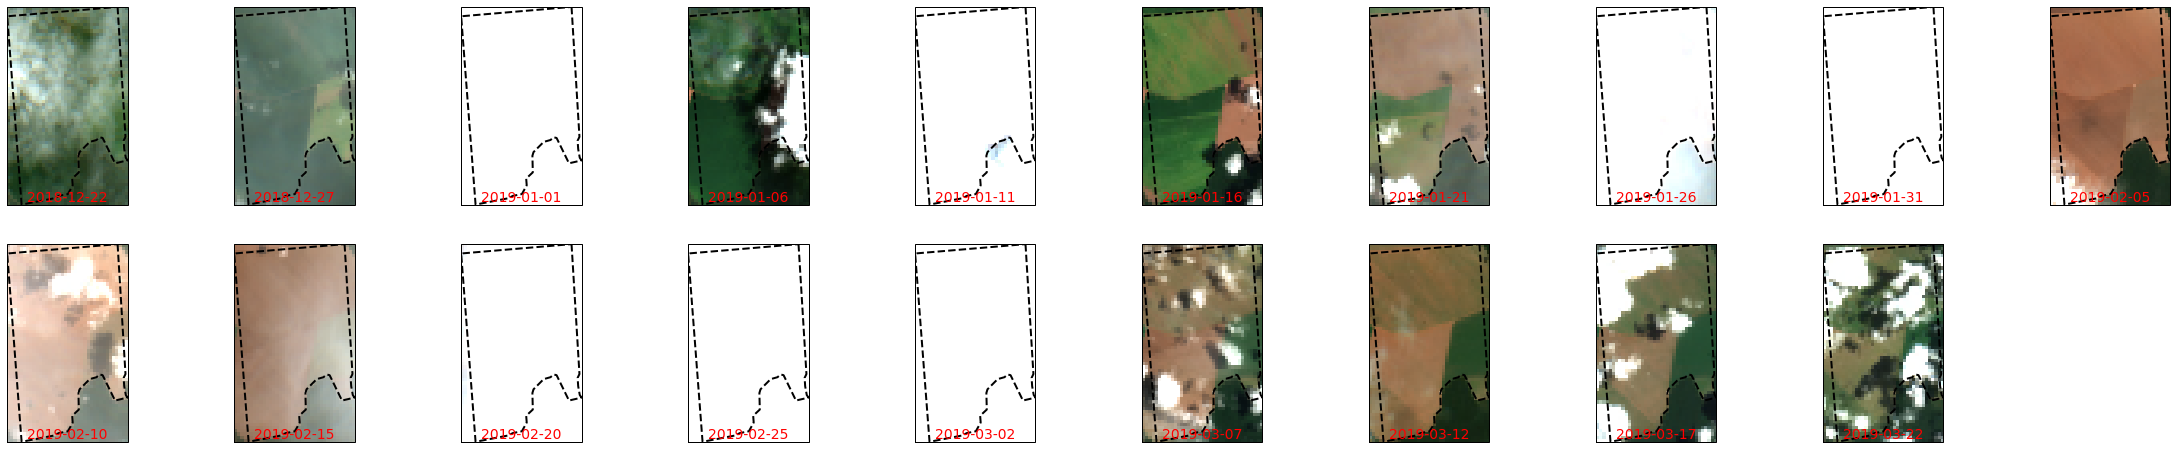

INFO:sentinelloader:> [done]    generating image patches. rows=2; cols=10 (29713.337 ms)
INFO:sentinelloader:Getting region history for band SCL from 2018-12-22 to 2019-03-27 at 60m
INFO:sentinelloader:Downloading tile uuid='a70e53cf-2c60-4ba5-aaef-ed3ac7728c4a', resolution='60m', band='SCL'


[==================================================]

INFO:sentinelloader:showing 20 images
INFO:sentinelloader:> [started] generating image patches. rows=3; cols=10...


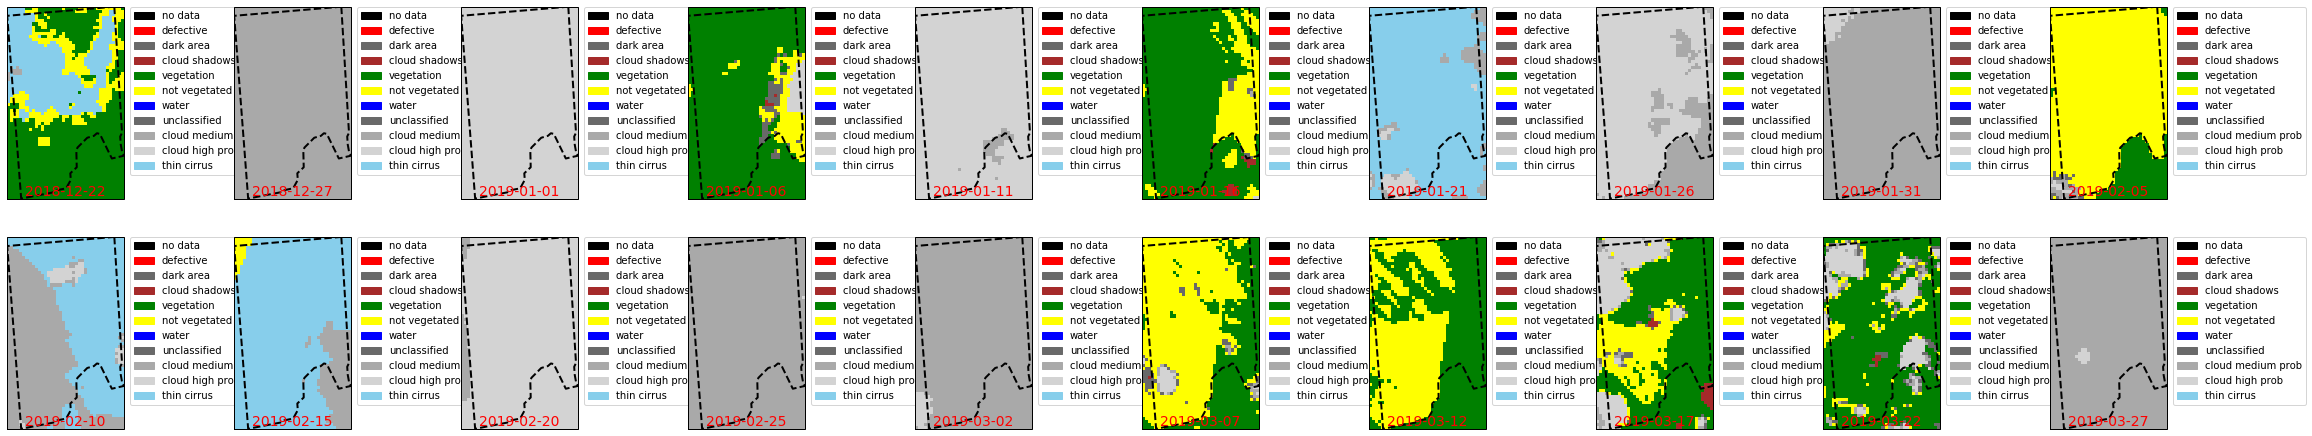

INFO:sentinelloader:> [done]    generating image patches. rows=3; cols=10 (37941.927 ms)
INFO:sentinelloader:Getting region history for band NDVI from 2018-12-22 to 2019-03-27 at 60m
INFO:sentinelloader:Downloading tile uuid='a70e53cf-2c60-4ba5-aaef-ed3ac7728c4a', resolution='60m', band='B04'


[==================================================]

INFO:sentinelloader:Downloading tile uuid='a70e53cf-2c60-4ba5-aaef-ed3ac7728c4a', resolution='60m', band='B09'


[==================================================]

INFO:sentinelloader:showing 20 images
INFO:sentinelloader:> [started] generating image patches. rows=3; cols=10...


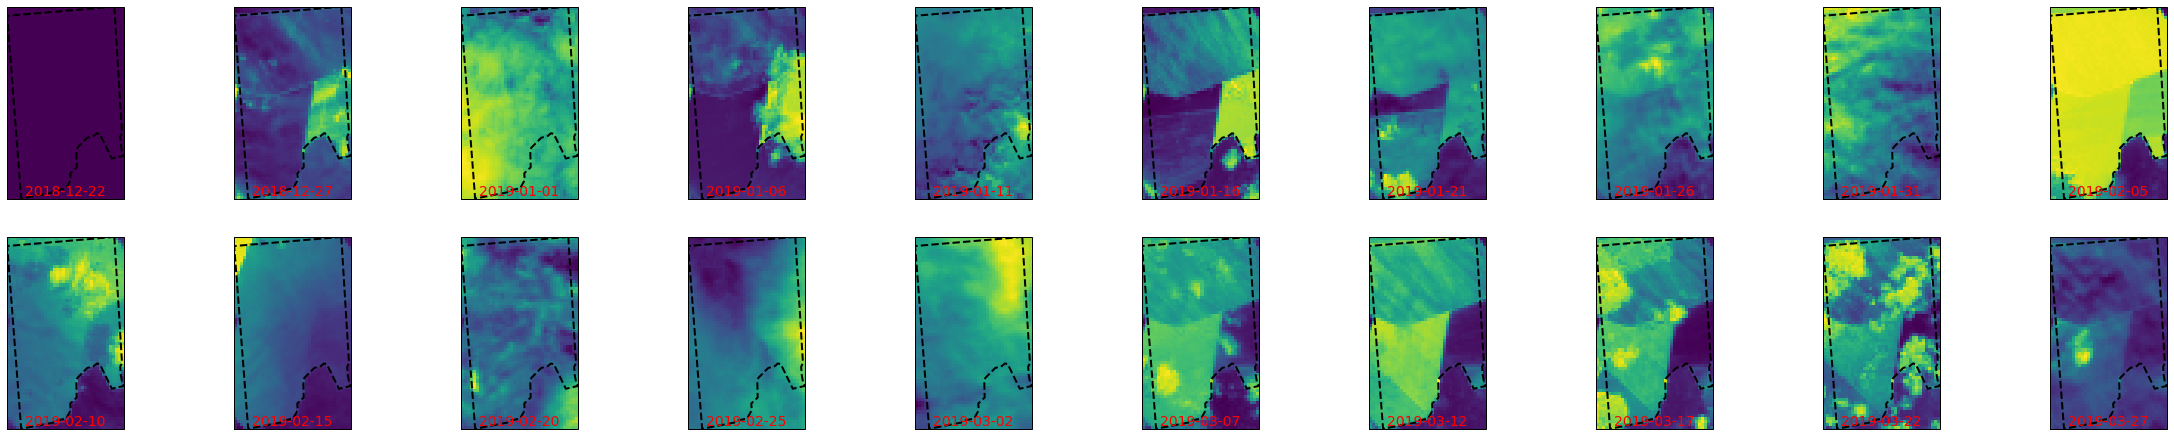

INFO:sentinelloader:> [done]    generating image patches. rows=3; cols=10 (33394.941 ms)


In [7]:
%matplotlib inline
import logging
import os
from osgeo import gdal
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
import geopandas as gpd
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from descartes import PolygonPatch
import fiona
from pprint import pprint
import re

logging.basicConfig(level=logging.INFO)

sl = SentinelLoader('/notebooks/data/output/sentinelcache', 
                    'flaviostutz', 'Through00',
                    apiUrl='https://scihub.copernicus.eu/apihub/', showProgressbars=True, cloudCoverage=(0,100))



df = gpd.read_file("/notebooks/data/input/sample2.shp")
df.crs = {'init' :'epsg:4326'}

coords = df['geometry'][0]




d1 = '2018-12-22'
d2 = '2019-03-27'
# d1 = '2019-01-11'
# d2 = '2019-02-06'

print(coords)
geoTiffs = sl.getRegionHistory(coords, 'TCI', '60m', d1, d2, daysStep=5)

geometries = []
labels = []
for geoTiff in geoTiffs:
    geometries.append(df)
    d = re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', geoTiff)
    labels.append(d.group(0))

showGeoTiffs(geoTiffs, geometries=geometries, labels=labels, cols=10, size=4,)

for geoTiff in geoTiffs:
    os.remove(geoTiff)

  




geoTiffs = sl.getRegionHistory(coords, 'SCL', '60m', d1, d2, daysStep=5)

geometries = []
labels = []
for geoTiff in geoTiffs:
    geometries.append(df)
    d = re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', geoTiff)
    labels.append(d.group(0))

showGeoTiffs(geoTiffs, geometries=geometries, labels=labels, cols=10, size=4, cmap=mpl.colors.ListedColormap(sclColors()), cmap_min=0, cmap_max=11, legendHandles=sclLegendPatches())

for geoTiff in geoTiffs:
    os.remove(geoTiff)


    
    
    
    
    
geoTiffs = sl.getRegionHistory(coords, 'NDVI', '60m', d1, d2, daysStep=5)

geometries = []
labels = []
for geoTiff in geoTiffs:
    geometries.append(df)
    d = re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', geoTiff)
    labels.append(d.group(0))

def td(data):
    return np.negative(data)
 
showGeoTiffs(geoTiffs, geometries=geometries, labels=labels, cols=10, size=4, transformData=td, cmap='viridis', interpolation='none')

for geoTiff in geoTiffs:
    os.remove(geoTiff)
    

    





# geoTiffs = sl.getRegionHistory(coords, 'NDVI', '60m', '2018-06-11', '2019-03-11', daysStep=5)

# geometries = []
# labels = []
# for geoTiff in geoTiffs:
#     geometries.append(df)
#     d = re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', geoTiff)
#     labels.append(d.group(0))

# def td(data):
# #     v[v>200] = 255
#     print(np.mean(data))
#     return data
 
# showGeoTiffs(geoTiffs, geometries=geometries, labels=labels, transformData=td, cmap='viridis', cmap_min=-1, cmap_max=1)

# for geoTiff in geoTiffs:
#     os.remove(geoTiff)

    
    
    
plt.show()